In [1]:
#basics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Tools for accessing and reading data (you do not need to use all of them)
import os
import pathlib
import PIL
#import cv2
#import skimage 
from IPython.display import Image, display
from matplotlib.image import imread
import matplotlib.cm as cm

# Tensorflow basics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


#Lime package for ML explainability
from lime import lime_image

# for reproducibility (does not guarantee fully reproducible results )
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [2]:
dataset_url = "casting_512x512/"
data_dir = pathlib.Path(dataset_url)
data_dir

WindowsPath('casting_512x512')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

1300


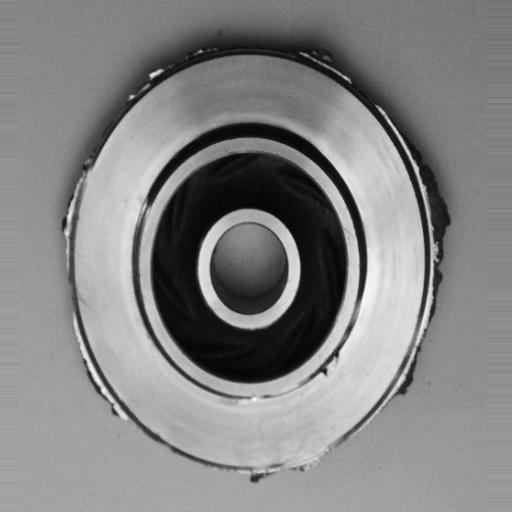

In [4]:
def_front = list(data_dir.glob('def_front/*'))
PIL.Image.open(def_front[0])

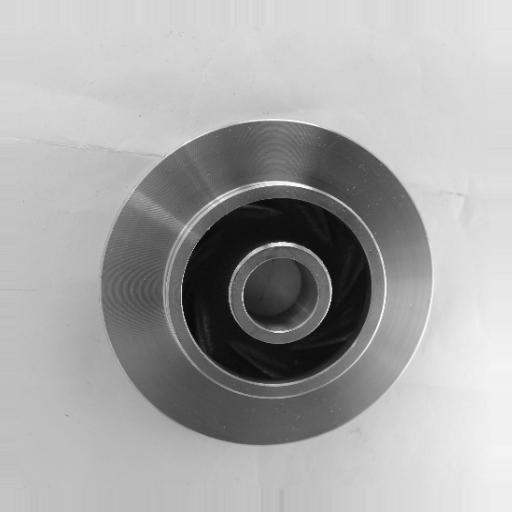

In [5]:
ok_front = list(data_dir.glob('ok_front/*'))
PIL.Image.open(ok_front[0])


In [6]:
sample1= imread(ok_front[0])
sample1.shape

(512, 512, 3)

In [7]:
batch_size = 64
epochs=200
img_height = 299
img_width = 299
img_size = (img_height, img_width)

In [8]:
train_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    class_names =  ['ok_front', 'def_front'],
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1300 files belonging to 2 classes.
Using 1040 files for training.


In [9]:
val_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    class_names =  ['ok_front', 'def_front'],
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1300 files belonging to 2 classes.
Using 260 files for validation.


In [10]:
class_names = train_set.class_names
print(class_names)

['ok_front', 'def_front']


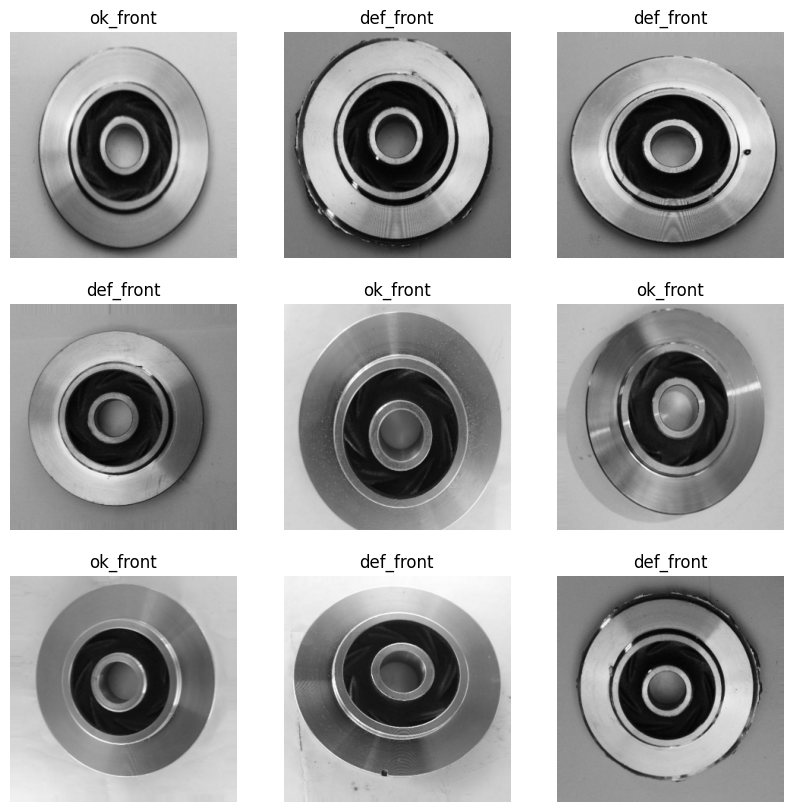

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for images, labels in train_set:
  print(images.shape)
  print(labels.shape)
  break

(64, 299, 299, 3)
(64,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_set.cache().shuffle(1300).prefetch(buffer_size=AUTOTUNE)
val_ds = val_set.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3), seed = seed ),
    layers.RandomZoom(0.1, seed = seed ),
    layers.RandomContrast(0.3, seed = seed  )
  ]
)


In [15]:
custom_model = Sequential([
    
  layers.Rescaling(1./255),
  data_augmentation,
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),


  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation = 'sigmoid')
])

In [16]:
custom_model.compile(optimizer='adam', 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])

In [17]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') == 1.0 and logs.get('val_accuracy') == 1.0 :
            print("\nReached 100% accuracy so cancelling training!")
            self.model.stop_training = True

terminate_callback =  myCallback()

In [18]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1,min_delta=0.01,
                              patience=5, min_lr=0.000001)



In [19]:
epochs=20

In [20]:
history1 = custom_model.fit(train_ds, 
                            validation_data=val_ds, 
                            epochs=epochs,
                            callbacks= [reduce_lr, terminate_callback]
)

Epoch 1/20
17/17 [==============================] - 122s 6s/step - loss: 0.6859 - accuracy: 0.6125 - val_loss: 0.6577 - val_accuracy: 0.5885 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - 110s 6s/step - loss: 0.6253 - accuracy: 0.6356 - val_loss: 0.5192 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - 107s 6s/step - loss: 0.5678 - accuracy: 0.7202 - val_loss: 0.4984 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 4/20
17/17 [==============================] - 103s 6s/step - loss: 0.5291 - accuracy: 0.7596 - val_loss: 0.4900 - val_accuracy: 0.7654 - lr: 0.0010
Epoch 5/20
17/17 [==============================] - 103s 6s/step - loss: 0.5243 - accuracy: 0.7452 - val_loss: 0.4728 - val_accuracy: 0.7808 - lr: 0.0010
Epoch 6/20
17/17 [==============================] - 99s 6s/step - loss: 0.5107 - accuracy: 0.7615 - val_loss: 0.5065 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 7/20
17/17 [==============================] - 101s 6s/step - loss: 0.46

In [21]:
custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 299, 299, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 149, 149, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                  

In [22]:
custom_model.save('yatharth_casting_product.h5')

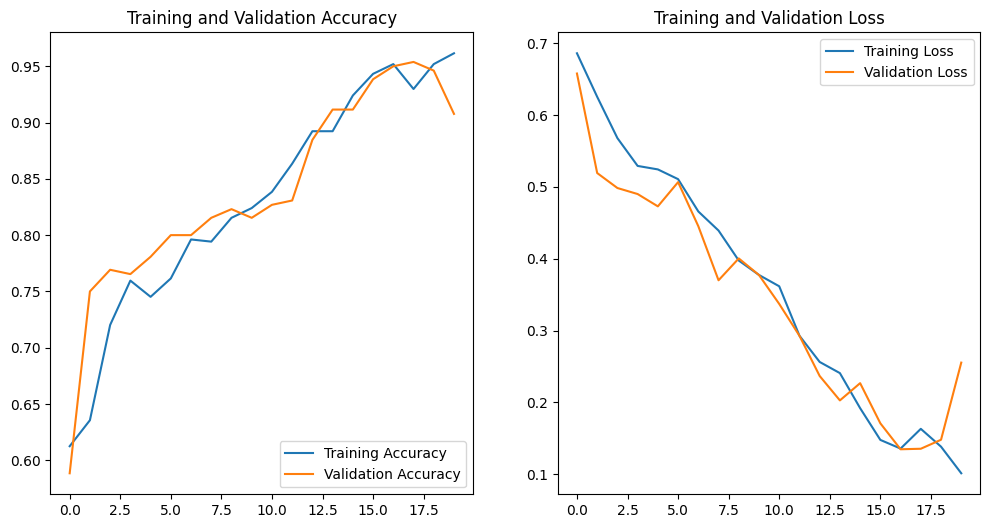

In [23]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
from tensorflow.keras.applications.xception import Xception

In [22]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [23]:
base_model = keras.applications.xception.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)

83683744/83683744 [==============================] - 14s 0us/step


In [24]:
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(img_height, img_width, 3))

x = data_augmentation(inputs)  # Apply random data augmentation

x = keras.layers.Rescaling(scale=1 / 255.0)(x)

x = base_model(x, training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation = 'relu')(x)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
pretrained_model = keras.Model(inputs, outputs)

In [25]:
pretrained_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [26]:
history2 = pretrained_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks= [reduce_lr, terminate_callback]
)

Epoch 1/20
17/17 [==============================] - 218s 12s/step - loss: 5.2903 - accuracy: 0.6615 - val_loss: 0.3410 - val_accuracy: 0.8923 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - 129s 8s/step - loss: 0.5177 - accuracy: 0.8798 - val_loss: 0.3405 - val_accuracy: 0.9192 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - 132s 8s/step - loss: 0.1394 - accuracy: 0.9615 - val_loss: 0.0657 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 4/20
17/17 [==============================] - 131s 8s/step - loss: 0.0630 - accuracy: 0.9837 - val_loss: 0.0372 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 5/20
17/17 [==============================] - 131s 8s/step - loss: 0.0254 - accuracy: 0.9885 - val_loss: 0.0241 - val_accuracy: 0.9885 - lr: 0.0010
Epoch 6/20
17/17 [==============================] - 136s 8s/step - loss: 0.0124 - accuracy: 0.9942 - val_loss: 0.0148 - val_accuracy: 0.9923 - lr: 0.0010
Epoch 7/20
17/17 [==============================] - 137s 8s/step - loss: 0.

In [27]:
pretrained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten_1 (Flatten)         (None, 204800)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               26214528  
                                                                 
 dense_3 (Dense)             (None, 1)                 129   

In [28]:
pretrained_model.save('yatharth_casting_product_xception.h5')

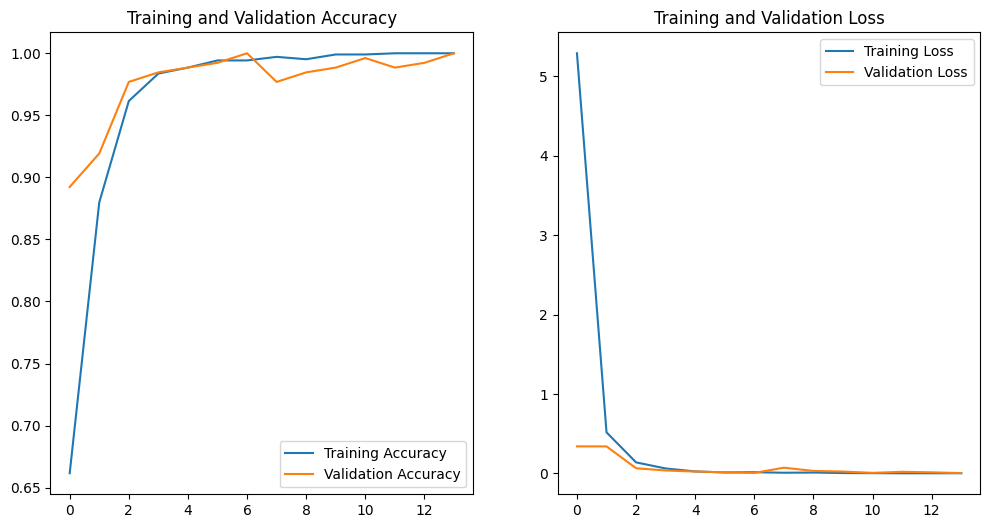

In [29]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

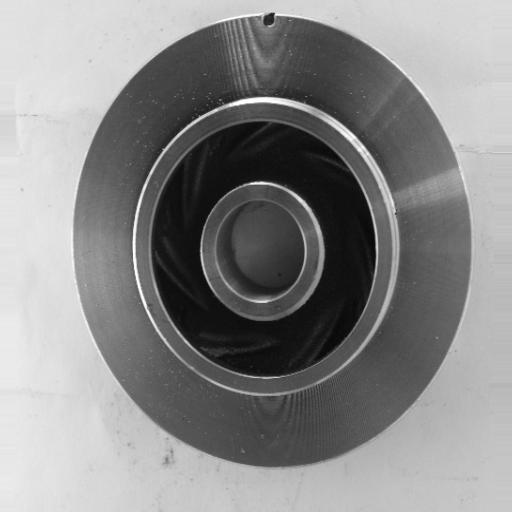

In [30]:
# The path to our target image
img_path = 'casting_512x512/def_front/cast_def_0_238.jpeg'
display(Image(img_path))

In [31]:
def get_img_array(img_path, size):
    # `Sİze of image 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [32]:
m_custom=load_model('yatharth_casting_product.h5')

In [33]:
images = get_img_array(img_path, img_size)
preds = m_custom.predict(images)
prediction = np.argmax(preds)
pct = np.max(preds)

1/1 [==============================] - 0s 422ms/step


In [34]:
if prediction == 1:
    print("ok")
else:
    print("not_ok")
    
print(pct)

not_ok
0.9828405


In [35]:
m_xception=load_model('yatharth_casting_product_xception.h5')

In [36]:
images = get_img_array(img_path, img_size)
preds = m_xception.predict(images)
prediction = np.argmax(preds)
pct = np.max(preds)

1/1 [==============================] - 2s 2s/step


In [37]:
if prediction == 1:
    print("ok")
else:
    print("not_ok")
    
print(pct)

not_ok
0.9999549
